In [1071]:
import numpy as np
import random
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import prettytable as pt
%matplotlib inline
sns.set_style("white")

In [1072]:
CLIFF_WIDTH =12
CLIFF_HEIGHT = 4
EPSILON = 0.1
ALPHA = 0.5
GAMMA = 1

UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

START_POINT = [3, 0]
END_POINT = [3, 11]

In [1073]:
def plotValueFunction(Qtable, title):
	V = []
	plt.figure(dpi=600)
	for i in range(0, CLIFF_HEIGHT):
		for j in range(0, CLIFF_WIDTH):
			V.append(np.max(Qtable[i, j, :]))
	V = np.reshape(V, (4,12))
	fig = plt.figure(figsize=(15,5))
	ax = fig.add_subplot(111)
	im = ax.imshow(V, cmap='cool')
	for (j,i),label in np.ndenumerate(V):
		ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
	plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
	plt.title(title)
	plt.show()
	

In [1074]:
def nextState(state, action):
    rows, cols = state
    reward = -1
    if action == UP:
        next_state = [max(rows - 1, 0), cols]
    elif action == DOWN:
        next_state = [min(rows + 1, CLIFF_HEIGHT - 1), cols]
    elif action == LEFT:
        next_state = [rows, max(cols -1 , 0)]
    elif action == RIGHT:
        next_state = [rows, min(cols + 1, CLIFF_WIDTH - 1)]
    
    if action == DOWN:
        if next_state[0] == 3 and next_state[1] in range(1, 11):
            reward = -100
            next_state = START_POINT
    if action == RIGHT and state == START_POINT:
            reward = -100
            next_state = START_POINT
         
    return next_state, reward
    
            
    

In [1075]:
def optimalPolicy(Qtable):
    optimal_policy = []
    for i in range(0, CLIFF_HEIGHT):
        optimal_policy.append([])
        for j in range(0, CLIFF_WIDTH):
            if [i, j] == END_POINT:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(Qtable[i, j, :])
            if bestAction == UP:
                optimal_policy[-1].append('U')
            elif bestAction == DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == RIGHT:
                optimal_policy[-1].append('R')
    return optimal_policy

In [1076]:
def findWay(optimal_policy):   
    currentStatus = '?'
    currentPos = [3, 0]

    while currentStatus != 'G':
        currentStatus = optimal_policy[currentPos[0]][currentPos[1]]
        optimal_policy[currentPos[0]][currentPos[1]] = 'O'
        if currentStatus == 'U':
            currentPos[0] -= 1
        elif currentStatus == 'D':
            currentPos[0] += 1
        elif currentStatus == 'L':
            currentPos[1] -= 1
        elif currentStatus == 'R':
            currentPos[1] += 1

    for i in range(0, CLIFF_HEIGHT):
        for j in range(0, CLIFF_WIDTH):
            currentStatus = optimal_policy[i][j]
            if currentStatus != 'O':
                optimal_policy[i][j]=''
    return optimal_policy
    

In [1077]:
def prettyTable(optimal_policy):
    tb = pt.PrettyTable()
    for row in optimal_policy:
        tb.add_row(row)
    tb.header = False    
    print(tb)

In [1078]:
def epsilonGreedy(state, Qtable):
    return np.random.choice(ACTIONS) if np.random.binomial(1, EPSILON) == 1 else np.argmax(Qtable[state[0], state[1], : ])
       

In [1079]:
def sarsa(Qtable):
    state = START_POINT
    action = epsilonGreedy(state, Qtable)
    total_reward = 0
    while state != END_POINT:
        next_state, reward = nextState(state, action)
        next_action = epsilonGreedy(next_state, Qtable)
        total_reward += reward
        target = Qtable[next_state[0], next_state[1], next_action]
        current = Qtable[state[0], state[1], action]
        update_Qtable = ALPHA * (reward + GAMMA * target - current)
        Qtable[state[0], state[1], action] += update_Qtable
        
        state = next_state
        action = next_action
    return total_reward



In [1080]:
def Qlearnning(Qtable):
    state = START_POINT
    total_reward = 0
    while state != END_POINT:
        action = epsilonGreedy(state, Qtable)
        next_state, reward = nextState(state, action)
        total_reward += reward

        target = np.max(Qtable[next_state[0], next_state[1], : ])
        current = Qtable[state[0], state[1], action]
        update_Qtable = ALPHA * (reward + GAMMA * target - current)
        Qtable[state[0], state[1], action] += update_Qtable
        
        state = next_state
    return total_reward

In [1081]:
def testQlearning(episodes, runs, reward_on_each_episode):
    Qtable = np.zeros((CLIFF_HEIGHT, CLIFF_WIDTH, 4))
    for r in tqdm(range(runs)):
        for i in range(0, episodes):
            reward_on_each_episode[i] += Qlearnning(Qtable)
    reward_on_each_episode /= runs
    return reward_on_each_episode, Qtable
    

In [1082]:
def testSarsa(episodes, runs, reward_on_each_episode):
    Qtable = np.zeros((CLIFF_HEIGHT, CLIFF_WIDTH, 4))
    for r in tqdm(range(runs)):
        for i in range(0, episodes):
            reward_on_each_episode[i] += sarsa(Qtable)
    reward_on_each_episode /= runs
    return reward_on_each_episode, Qtable

In [1083]:
def train():
    episodes = 500
    runs = 50
    
    reward_on_each_episode_sarsa = np.zeros(episodes)
    reward_on_each_episode_Qlearning = np.zeros(episodes)
    
    reward_on_each_episode_sarsa, sarsaQtable= testSarsa(episodes, runs, reward_on_each_episode_sarsa)
    reward_on_each_episode_Qlearning, QlearnningQtable =testQlearning(episodes, runs, reward_on_each_episode_Qlearning)

    

    optimal_policy_sarsa = optimalPolicy(sarsaQtable)
    optimal_policy_Qlearning = optimalPolicy(QlearnningQtable)
    print("Sarsa Optimal Policy")
    prettyTable(optimal_policy_sarsa)
    print("Qlearning Optimal Policy")
    prettyTable(optimal_policy_Qlearning)

    sarsa_path = findWay(optimal_policy_sarsa)
    Qlearning_path = findWay(optimal_policy_Qlearning)

    
    print("Sarsa Optimal Path")
    prettyTable(sarsa_path)
    print("Qlearning Optimal Path")
    prettyTable(Qlearning_path)

    plt.figure(dpi=600)
    plt.plot(reward_on_each_episode_sarsa, label='Sarsa')
    plt.plot(reward_on_each_episode_Qlearning, label='Q-Learning')
    plt.xlabel('Epoch')
    plt.ylabel('Average reward of each epoch')
    plt.ylim([-100, 0])
    plt.legend()
    plt.show()

    plotValueFunction(sarsaQtable, "Sarsa State Value Function")
    plotValueFunction(QlearnningQtable, "Qlearning State Value Function")

100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


Sarsa Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| L | R | R | R | R | R | R | R | R | R | D | D |
| R | R | R | U | U | U | R | U | R | R | R | D |
| R | U | U | U | U | U | U | U | U | U | R | D |
| U | U | U | U | U | U | U | U | U | U | U | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
Qlearning Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| D | R | D | D | R | R | D | D | D | D | D | D |
| D | D | D | D | D | D | D | D | D | D | D | D |
| R | R | R | R | R | R | R | R | R | R | R | D |
| U | U | U | U | U | U | U | U | U | U | U | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
Sarsa Optimal Path
+---+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   | O | O | O | O | O | O | O | O |   |
|   | O | O | O |   |   |   |   |   |   | O | O |
| O | O |   |   |   |   |   |   |   |   |   | O |
| O |   |   |   |   |   |   |   |   |   |   | O |
+---+---+---+---+---+---+---+---+---+---+---+---+
Qlearning Optimal Path
+---+---+---

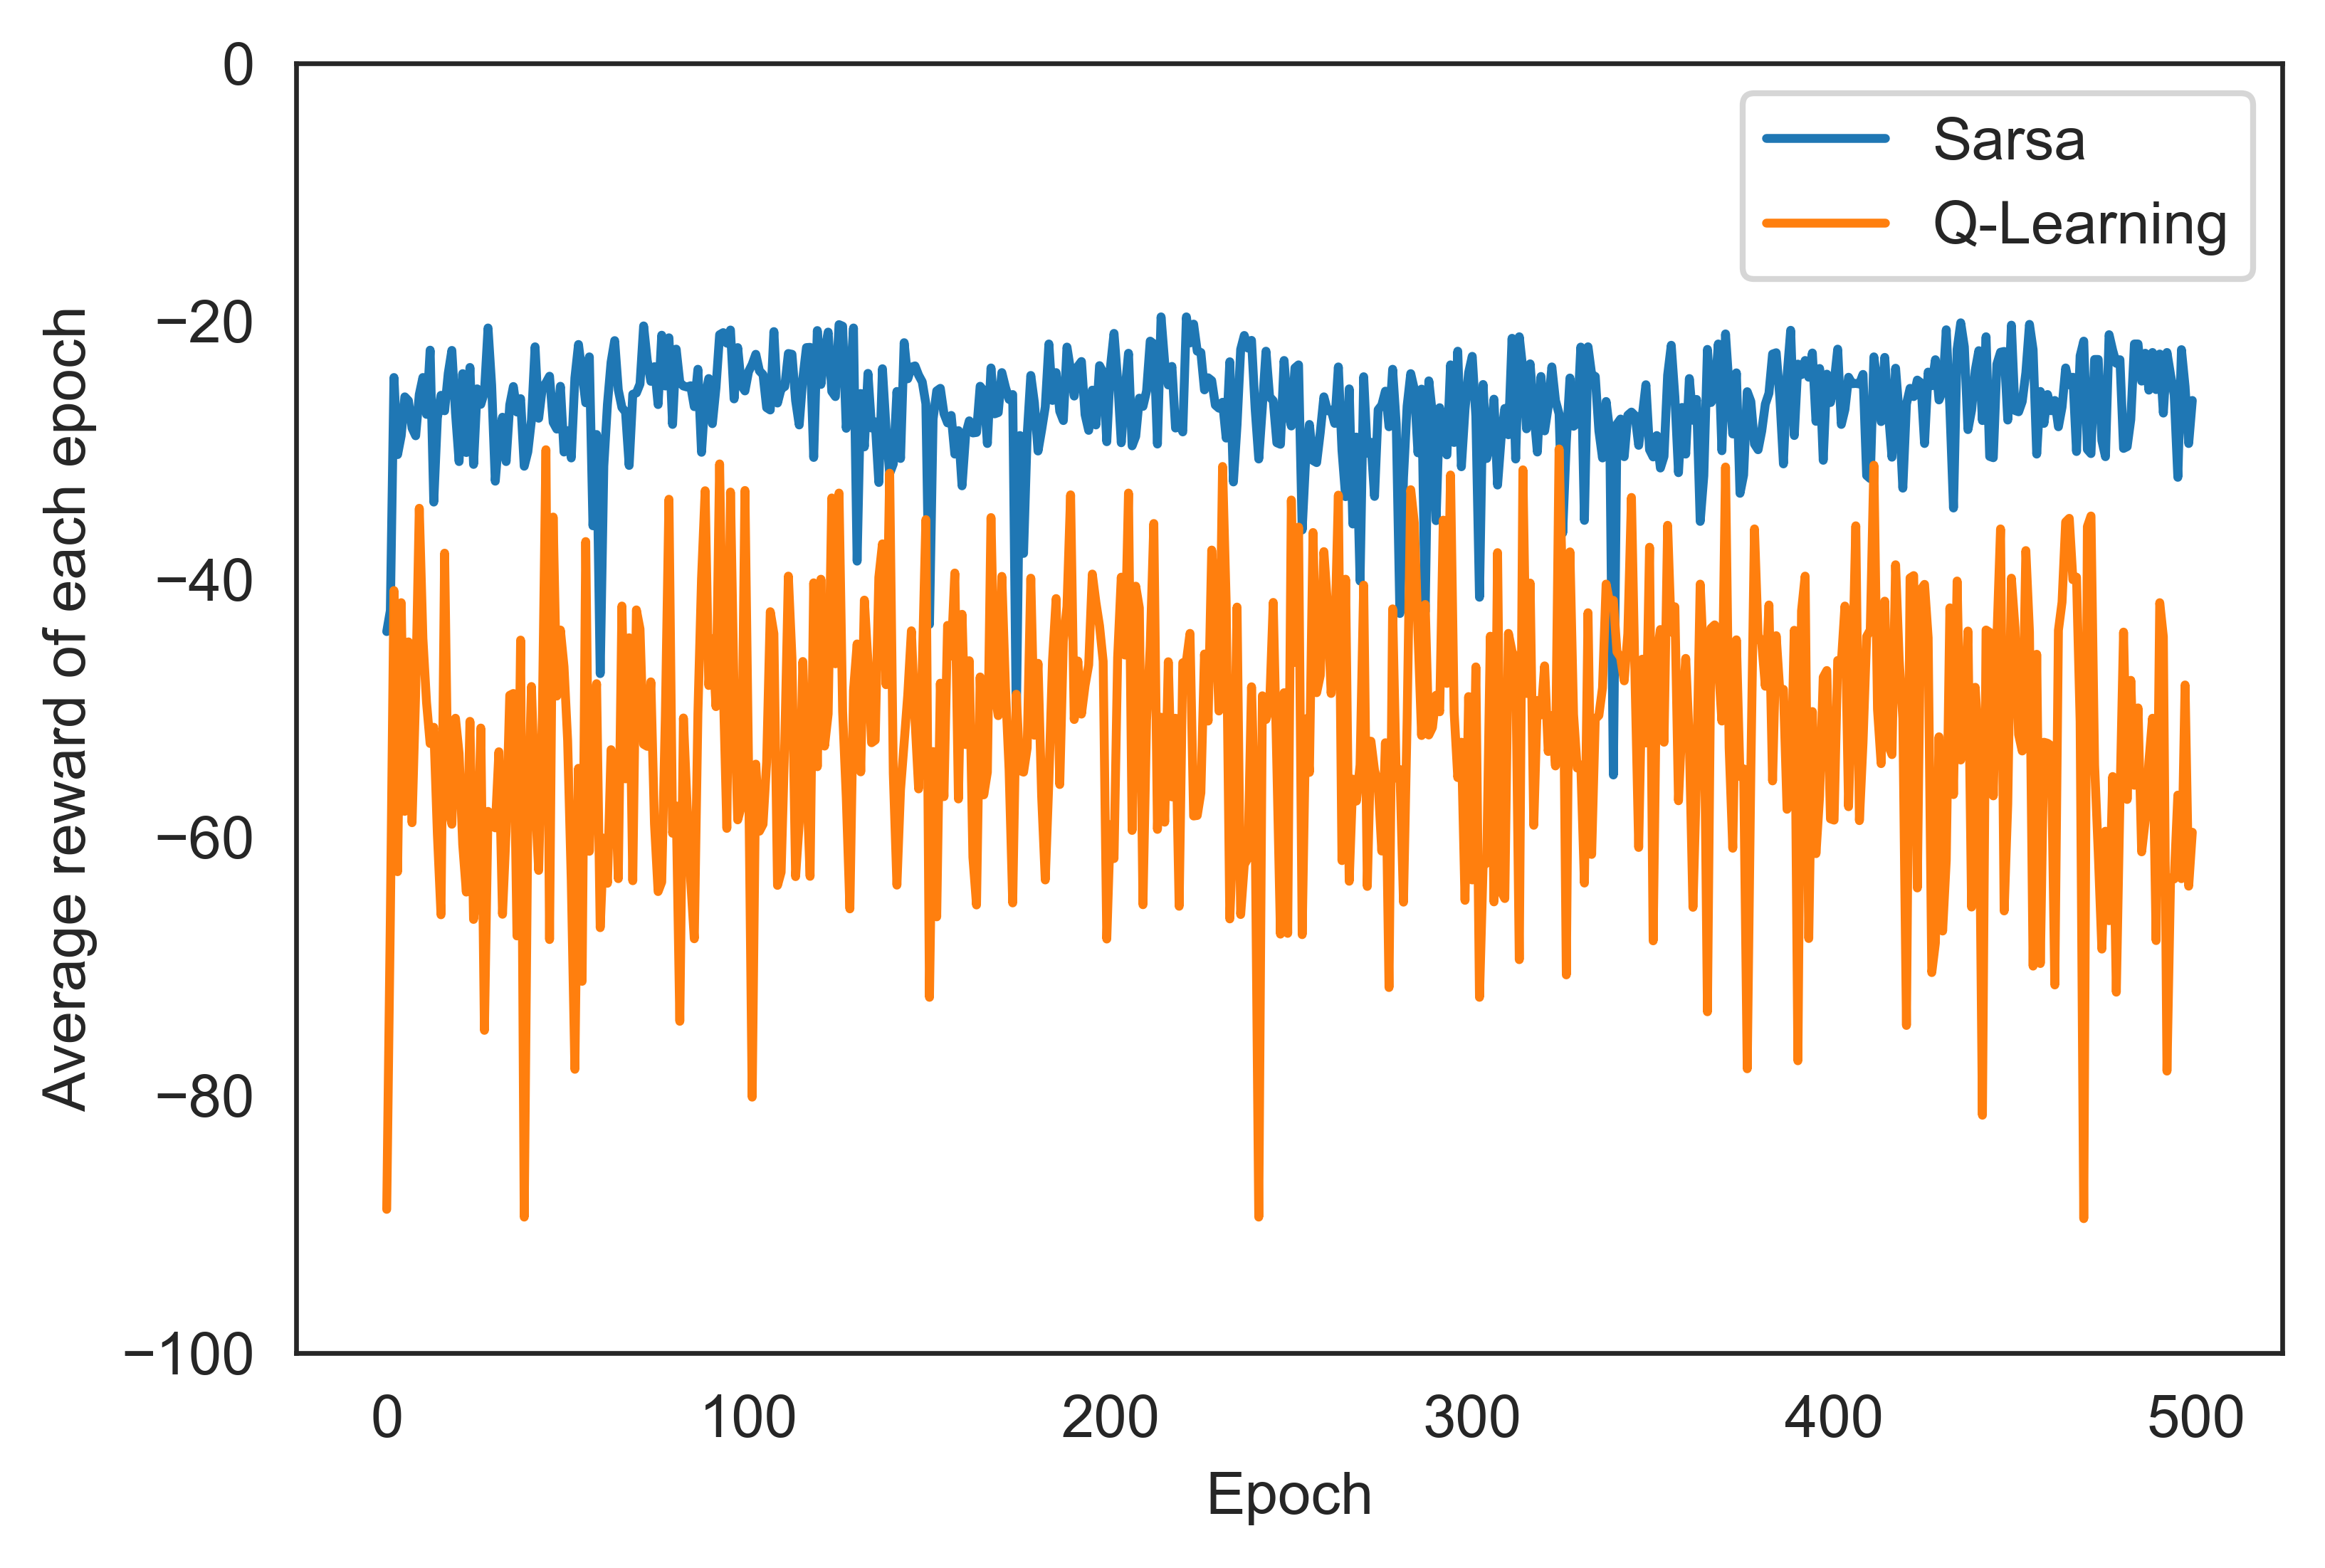

<Figure size 3600x2400 with 0 Axes>

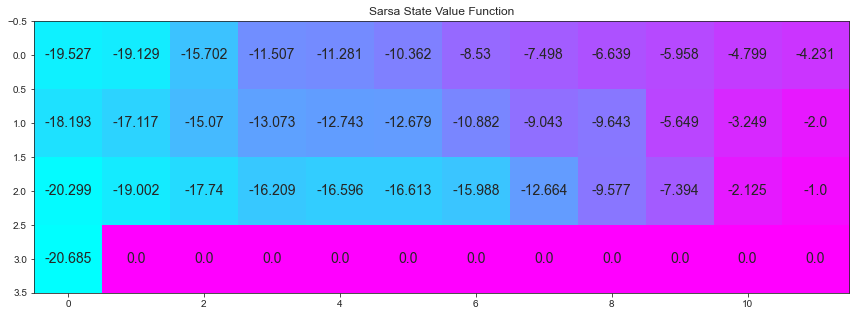

<Figure size 3600x2400 with 0 Axes>

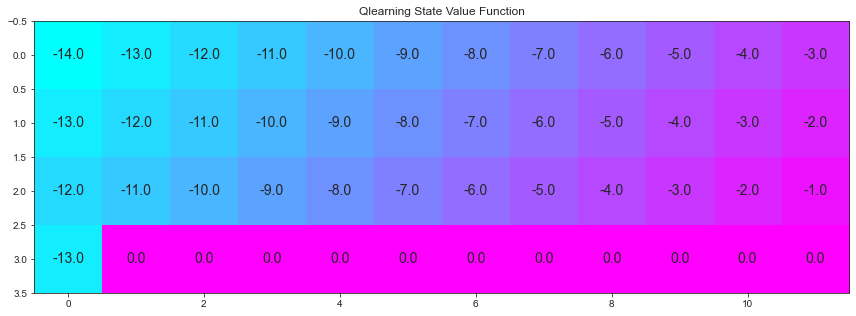

In [1084]:
train()

100%|██████████| 50/50 [00:09<00:00,  5.49it/s]


Sarsa Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| R | R | R | R | R | R | R | R | R | R | D | D |
| U | R | R | R | R | R | R | R | R | R | R | D |
| U | R | U | L | U | L | R | R | R | R | R | D |
| U | U | U | U | U | U | U | U | U | U | U | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
Qlearning Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| U | R | R | R | L | L | R | D | R | L | U | U |
| L | D | R | L | R | R | U | R | R | R | R | D |
| R | R | R | R | R | R | R | R | R | R | R | D |
| U | U | U | U | U | U | U | U | U | U | U | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
Sarsa Optimal Path
+---+---+---+---+---+---+---+---+---+---+---+---+
| O | O | O | O | O | O | O | O | O | O | O |   |
| O |   |   |   |   |   |   |   |   |   | O | O |
| O |   |   |   |   |   |   |   |   |   |   | O |
| O |   |   |   |   |   |   |   |   |   |   | O |
+---+---+---+---+---+---+---+---+---+---+---+---+
Qlearning Optimal Path
+---+---+---

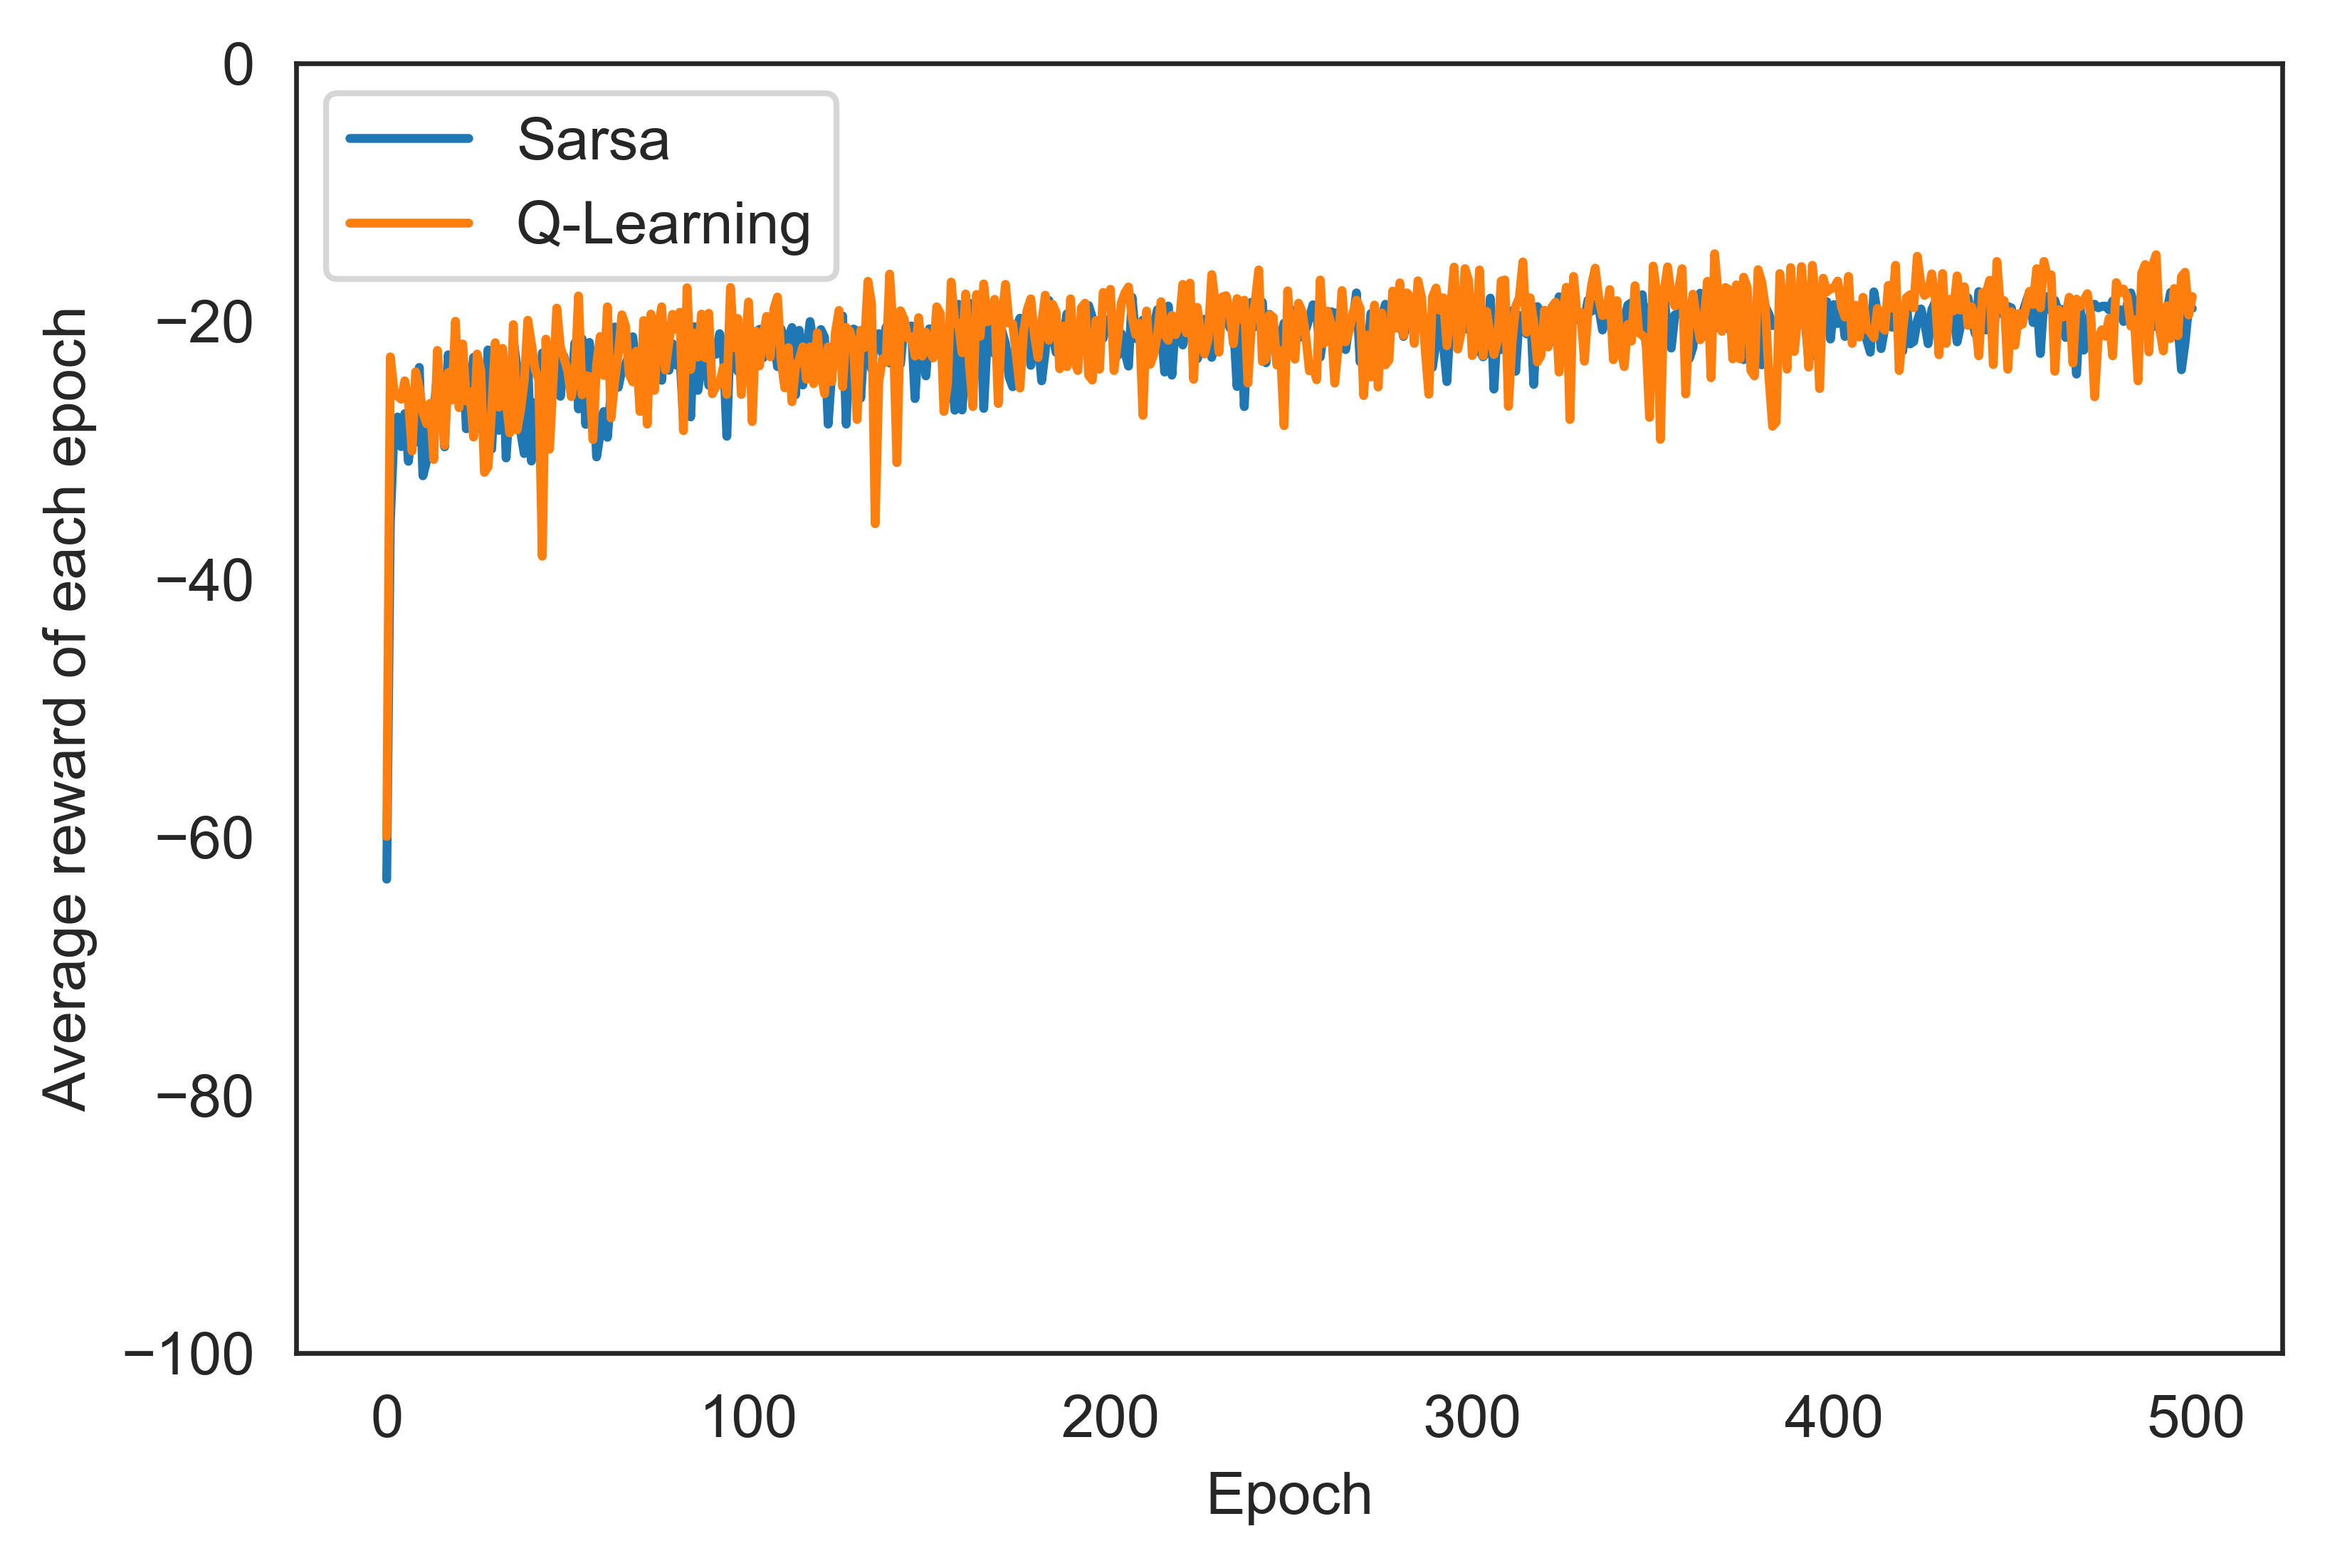

<Figure size 3600x2400 with 0 Axes>

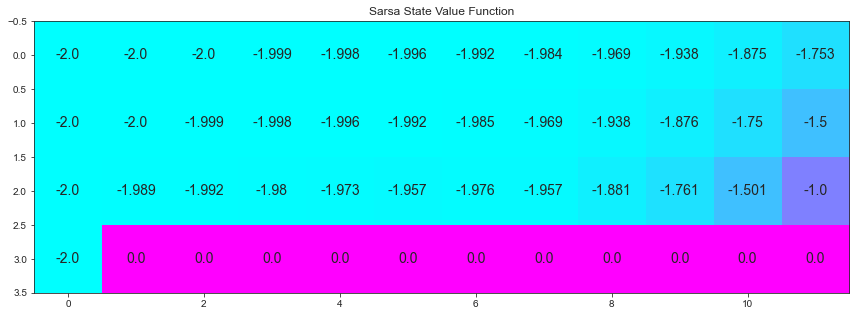

<Figure size 3600x2400 with 0 Axes>

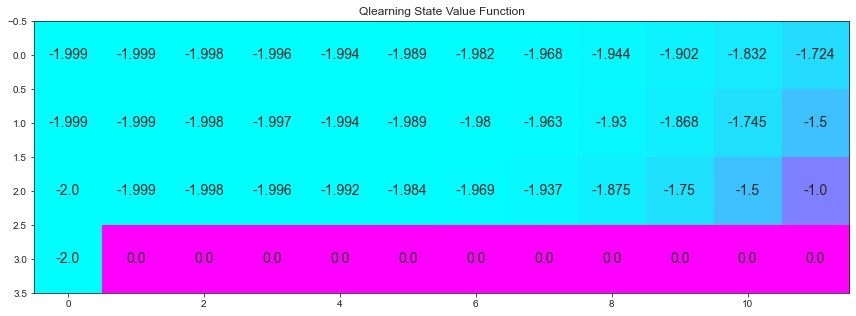

In [1085]:
EPSILON = 0.01
ALPHA = 0.01
GAMMA = 0.5
train()

100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


Sarsa Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| U | R | D | U | R | R | R | D | U | R | R | D |
| R | R | R | R | R | R | R | R | R | R | R | D |
| U | R | R | R | R | R | R | R | R | R | R | D |
| U | U | U | U | U | U | U | U | U | U | U | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
Qlearning Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| R | L | R | U | U | R | L | R | U | D | R | U |
| U | R | R | R | R | R | R | R | D | R | D | D |
| R | R | R | R | R | R | R | R | R | R | R | D |
| U | U | U | U | U | U | U | U | U | U | U | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
Sarsa Optimal Path
+---+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |   |   |
| O | O | O | O | O | O | O | O | O | O | O | O |
| O |   |   |   |   |   |   |   |   |   |   | O |
| O |   |   |   |   |   |   |   |   |   |   | O |
+---+---+---+---+---+---+---+---+---+---+---+---+
Qlearning Optimal Path
+---+---+---

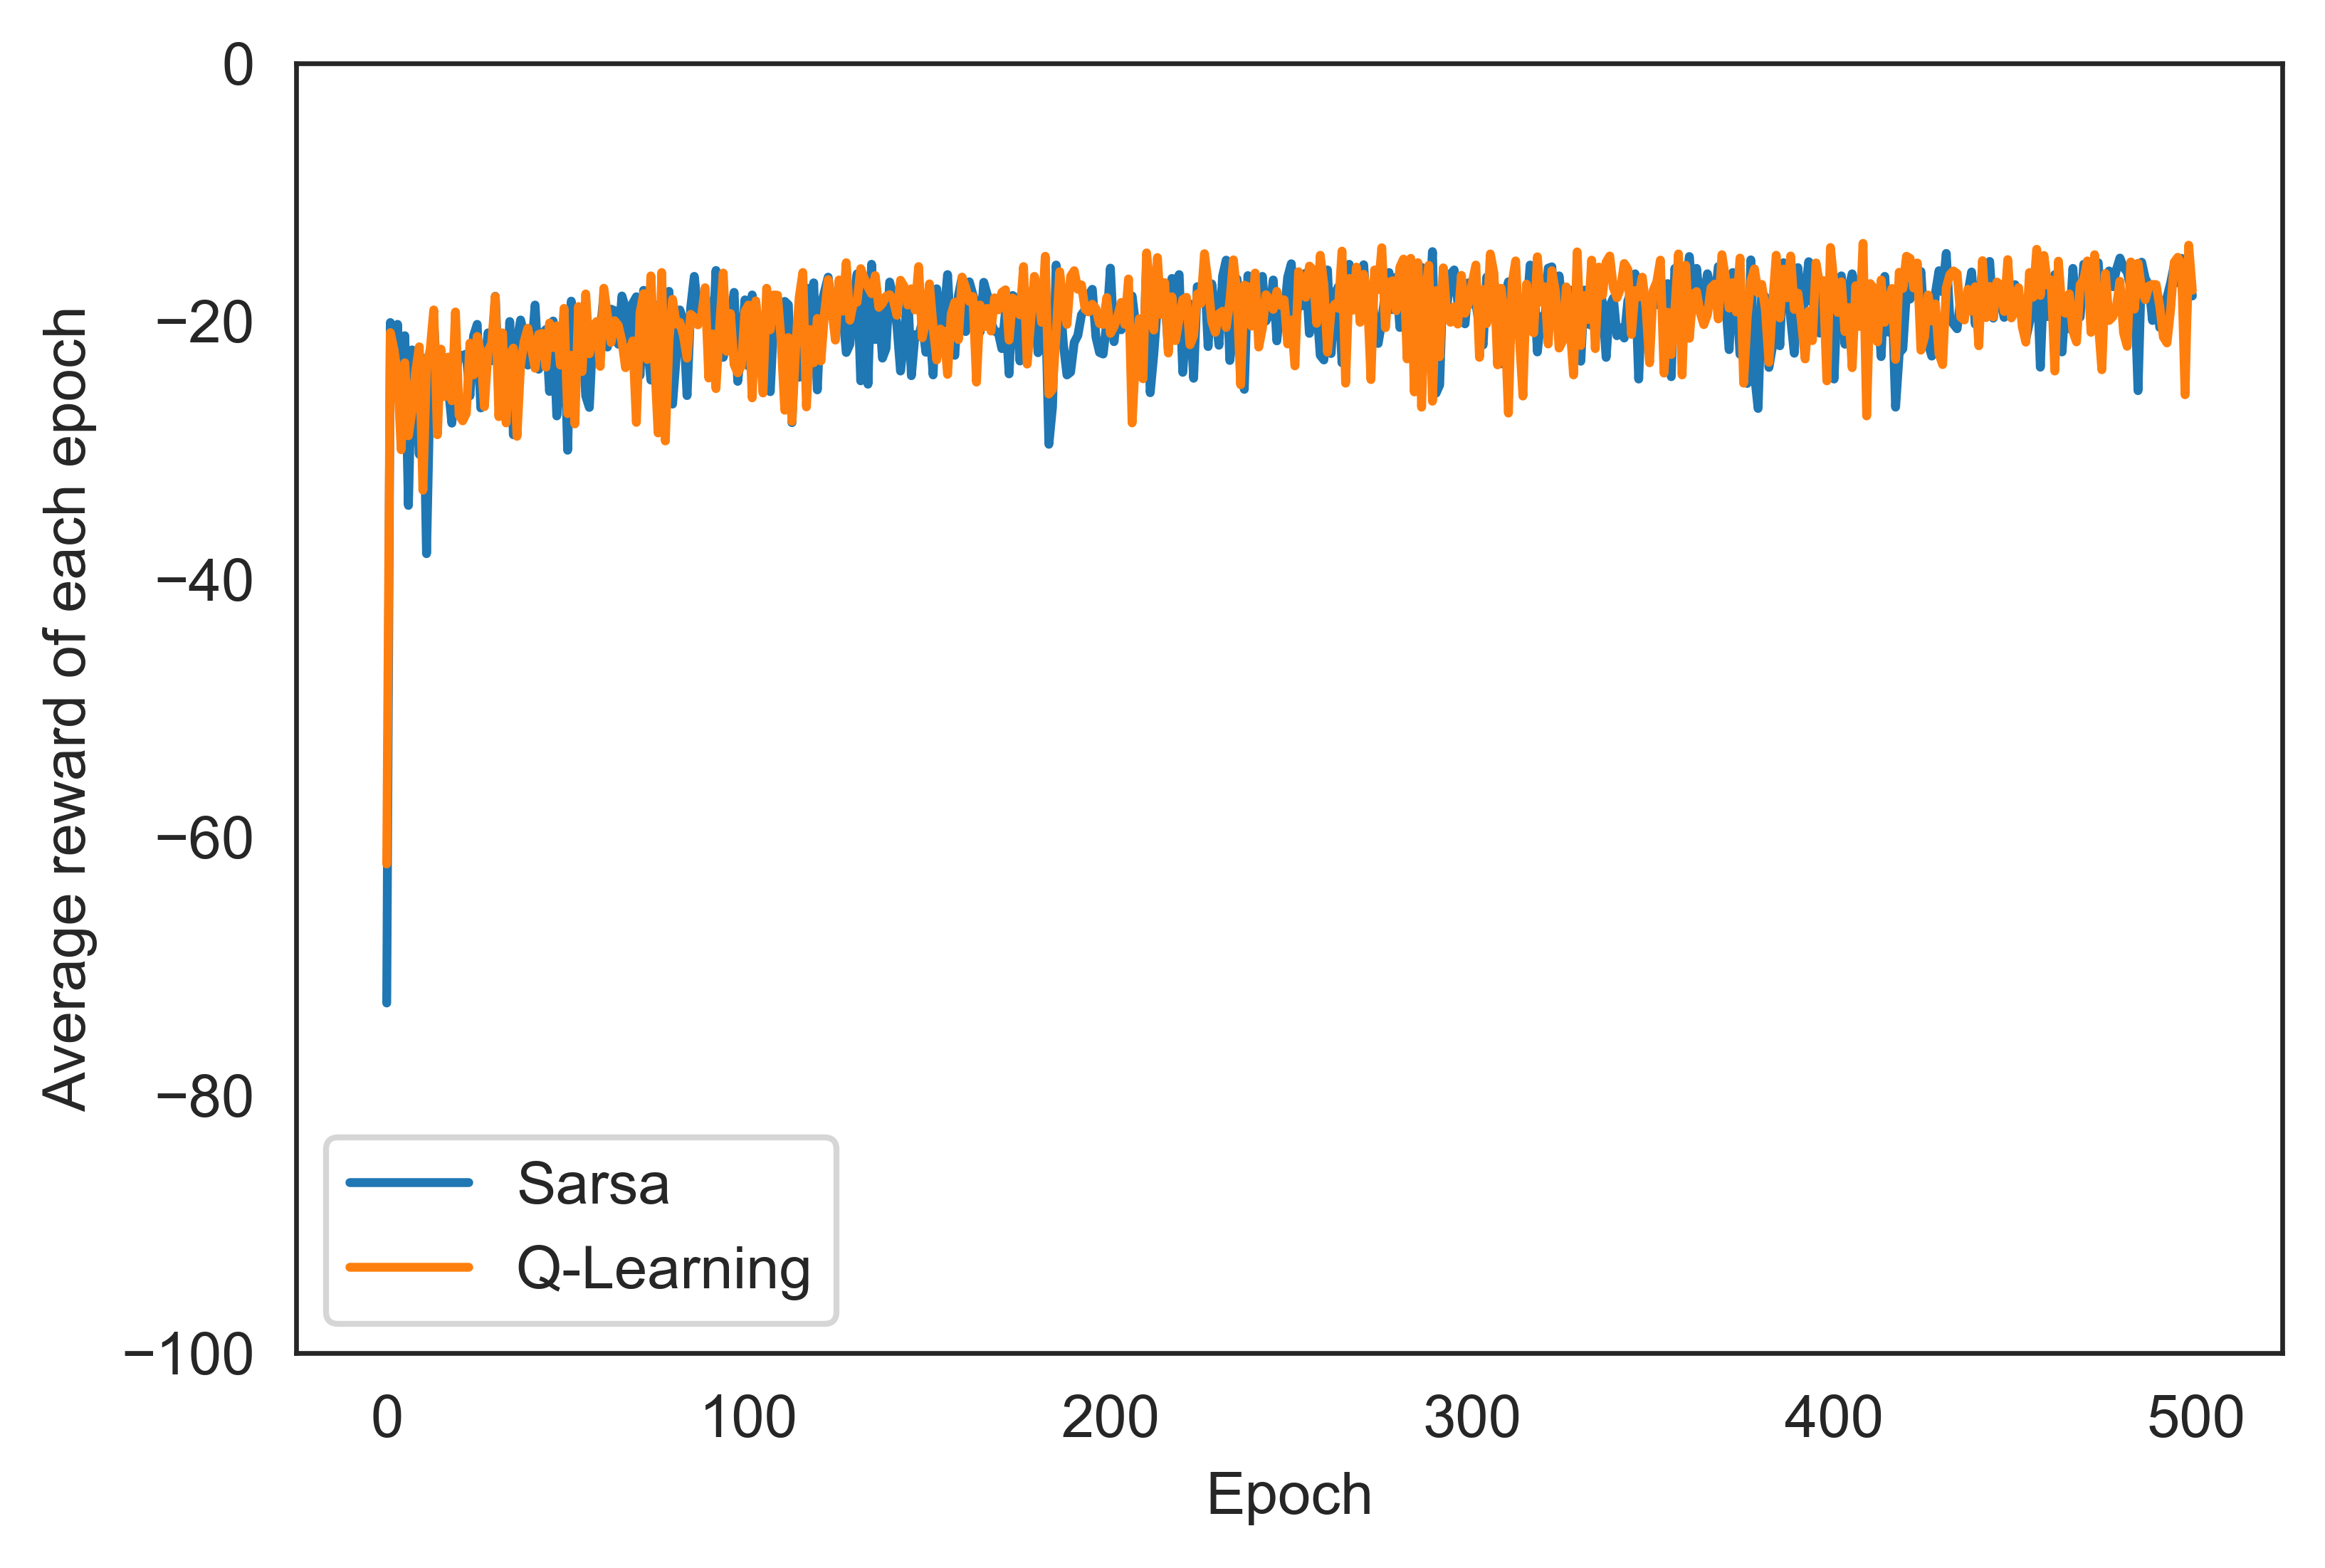

<Figure size 3600x2400 with 0 Axes>

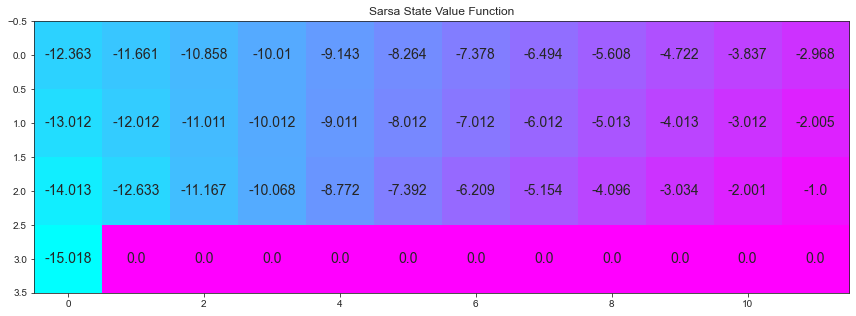

<Figure size 3600x2400 with 0 Axes>

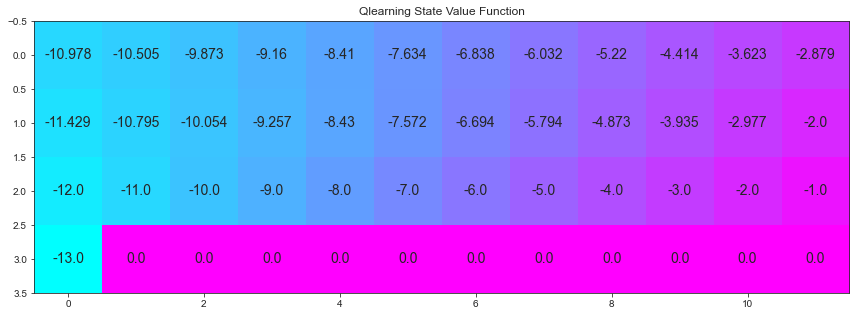

In [1086]:
EPSILON = 0.01
ALPHA = 0.01
GAMMA = 1
train()